# MLP on the CIFAR-10 Dataset

Trains four simple NNs with 3 hidden layers on the CIFAR-10 dataset. (5 runs, seed = 10, 20, 30, 40, 50)

1. 3072-4000-3072-4000-10 (Res Connect; MSE; lr = 0.05): validation accuracies: 0.4968, 0.489, 0.4899, 0.49, 0.4934

2. 3072-4000-1000-4000-10 (MLP; MSE; lr = 0.05): validation accuracies: 0.4699, 0.4686, 0.4723, 0.4699, 0.4711

3. 3072-4000-3072-4000-10 (Res Connect; hinge loss; lr = 0.05): validation accuracies: 0.5166, 0.5219, 0.5009, 0.5093, 0.503

4. 3072-4000-1000-4000-10 (MLP; hinge loss; lr = 0.05): validation accuracies: 0.414, 0.4147, 0.4475, 0.4382, 0.4335

~2 seconds per epoch on 4 GTX1080Ti GPUs.

## Import the Tensorflow package (for Keras) and Reproducility

In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'

seed = 50

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(seed)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=4)

# from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

## Import the CIFAR-10 dataset

In [2]:
batch_size = 512
num_classes = 10
epochs = 100

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

#print(x_train[0,0:10,0,0])

50000 train samples
10000 test samples


## Visualize Some Training Samples

The first 5 images, followed by 25 random images:


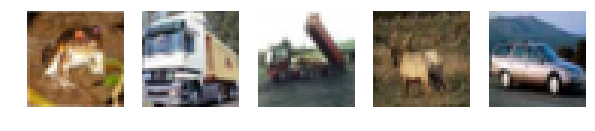

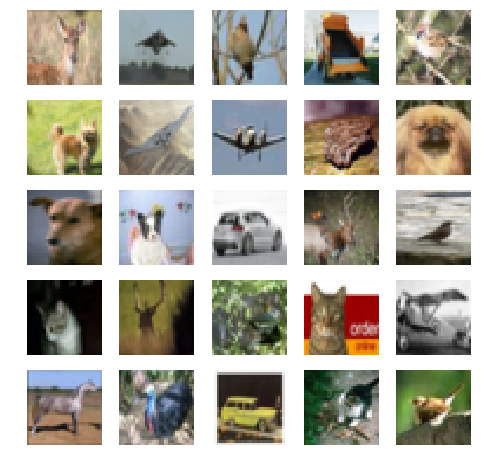

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1,5,figsize=(10,10))
print('The first 5 images, followed by 25 random images:')
for i in range(5):
    axes[i].set_axis_off()
    axes[i].imshow(x_train[i], interpolation='nearest')

fig1, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(x_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x_train[i:i+1][0], interpolation='nearest')

## Data Transformation

In [4]:
x_train = x_train.reshape((50000, 3*32*32), order='F') # reshaping order fixed to the same as BCD
x_test = x_test.reshape((10000, 3*32*32), order='F') # reshaping order fixed to the same as BCD
#print(x_train[0,0:10])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# The First Model (Residual Connection) (MSE)

## Model Setup

Input -> Fully Connected (4000) -> ReLU -> Fully Connected (3072) -> Add Input -> ReLU -> Fully Connected (4000) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [5]:
# model
x1 = tf.keras.layers.Input(shape=(3072,))
a1 = tf.keras.layers.Dense(4000, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(x1)
a2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(a1)
a2 = tf.keras.layers.Add()([a2, x1])
a3 = tf.keras.layers.Dense(4000, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(a2)
y_mlp = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(a3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model = tf.keras.models.Model(inputs=x1, outputs=y_mlp)

model.summary()

sgd1 = tf.keras.optimizers.SGD(lr=0.05, decay=0, momentum=0, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd1, metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4000)         12292000    input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3072)         12291072    dense_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 3072)         0           dense_2[0][0]                    
                                                                 input_1[0][0]                    
__________

## Fit the Model using Back Propagation (Vanilla SGD; lr = 0.05)

In [6]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 3s - loss: 0.2367 - acc: 0.2273 - val_loss: 0.0841 - val_acc: 0.3035
Epoch 2/100
 - 3s - loss: 0.0829 - acc: 0.3237 - val_loss: 0.0820 - val_acc: 0.3359
Epoch 3/100
 - 3s - loss: 0.0814 - acc: 0.3476 - val_loss: 0.0809 - val_acc: 0.3571
Epoch 4/100
 - 3s - loss: 0.0804 - acc: 0.3636 - val_loss: 0.0800 - val_acc: 0.3686
Epoch 5/100
 - 2s - loss: 0.0797 - acc: 0.3740 - val_loss: 0.0794 - val_acc: 0.3787
Epoch 6/100
 - 2s - loss: 0.0790 - acc: 0.3818 - val_loss: 0.0788 - val_acc: 0.3880
Epoch 7/100
 - 3s - loss: 0.0785 - acc: 0.3885 - val_loss: 0.0783 - val_acc: 0.3961
Epoch 8/100
 - 3s - loss: 0.0780 - acc: 0.3940 - val_loss: 0.0778 - val_acc: 0.4028
Epoch 9/100
 - 2s - loss: 0.0775 - acc: 0.4001 - val_loss: 0.0774 - val_acc: 0.4075
Epoch 10/100
 - 3s - loss: 0.0771 - acc: 0.4053 - val_loss: 0.0770 - val_acc: 0.4118
Epoch 11/100
 - 2s - loss: 0.0767 - acc: 0.4098 - val_loss: 0.0767 - val_acc: 0.4150
Epoch 12/100
 - 3s - los

Epoch 97/100
 - 3s - loss: 0.0658 - acc: 0.5309 - val_loss: 0.0686 - val_acc: 0.4924
Epoch 98/100
 - 3s - loss: 0.0657 - acc: 0.5319 - val_loss: 0.0686 - val_acc: 0.4932
Epoch 99/100
 - 2s - loss: 0.0657 - acc: 0.5326 - val_loss: 0.0686 - val_acc: 0.4938
Epoch 100/100
 - 3s - loss: 0.0656 - acc: 0.5333 - val_loss: 0.0686 - val_acc: 0.4934
Test loss: 0.06858388967514038
Test accuracy: 0.4934


## Loss and Accuracy Plots

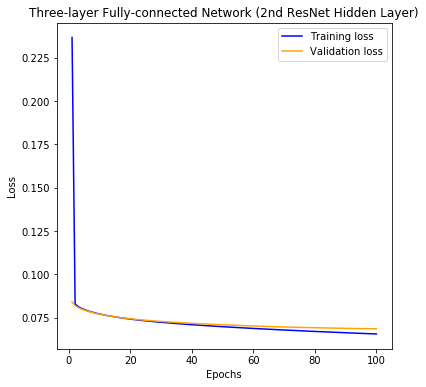

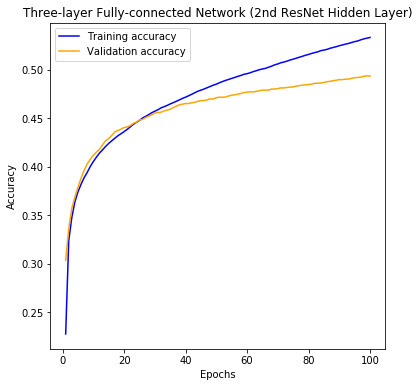

In [7]:
# Plot of Losses
history_dict = history.history
# history_dict.keys()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs_index = range(1,len(loss_values)+1)

fig_loss = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values, 'b', c='orange', label='Validation loss')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [8]:
fig_accuracy.savefig('fig_accuracy_cifar.eps', format='eps', dpi=2000)

# The Second Model (MLP) (MSE)

## Model Setup

Input -> Fully Connected (4000) -> ReLU -> Fully Connected (1000) -> ReLU -> Fully Connected (4000) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [9]:
# model
x0 = tf.keras.layers.Input(shape=(3072,))
u1 = tf.keras.layers.Dense(4e3, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(x0)
u2 = tf.keras.layers.Dense(1e3, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(u1)
u3 = tf.keras.layers.Dense(4e3, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(u2)
y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(u3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model_2 = tf.keras.models.Model(inputs=x0, outputs=y_mlp_2)

model_2.summary()

sgd2 = tf.keras.optimizers.SGD(lr=0.05, decay=0, momentum=0, nesterov=False)
model_2.compile(loss='mean_squared_error', optimizer=sgd2, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              12292000  
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              4001000   
_________________________________________________________________
dense_7 (Dense)              (None, 4000)              4004000   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                40010     
Total params: 20,337,010
Trainable params: 20,337,010
Non-trainable params: 0
_________________________________________________________________


## Fit the Model using Back Propagation (Vanilla SGD; lr = 0.05)

In [10]:
history_2 = model_2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score_2 = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])
#print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 2s - loss: 0.0881 - acc: 0.2136 - val_loss: 0.0866 - val_acc: 0.2397
Epoch 2/100
 - 2s - loss: 0.0855 - acc: 0.2853 - val_loss: 0.0847 - val_acc: 0.2823
Epoch 3/100
 - 2s - loss: 0.0841 - acc: 0.3054 - val_loss: 0.0836 - val_acc: 0.3039
Epoch 4/100
 - 2s - loss: 0.0832 - acc: 0.3201 - val_loss: 0.0828 - val_acc: 0.3217
Epoch 5/100
 - 2s - loss: 0.0825 - acc: 0.3320 - val_loss: 0.0823 - val_acc: 0.3310
Epoch 6/100
 - 2s - loss: 0.0820 - acc: 0.3408 - val_loss: 0.0818 - val_acc: 0.3408
Epoch 7/100
 - 2s - loss: 0.0815 - acc: 0.3489 - val_loss: 0.0814 - val_acc: 0.3507
Epoch 8/100
 - 2s - loss: 0.0811 - acc: 0.3550 - val_loss: 0.0810 - val_acc: 0.3583
Epoch 9/100
 - 2s - loss: 0.0808 - acc: 0.3609 - val_loss: 0.0807 - val_acc: 0.3669
Epoch 10/100
 - 2s - loss: 0.0804 - acc: 0.3653 - val_loss: 0.0804 - val_acc: 0.3714
Epoch 11/100
 - 2s - loss: 0.0801 - acc: 0.3698 - val_loss: 0.0801 - val_acc: 0.3751
Epoch 12/100
 - 2s - los

Epoch 97/100
 - 2s - loss: 0.0690 - acc: 0.4822 - val_loss: 0.0702 - val_acc: 0.4702
Epoch 98/100
 - 2s - loss: 0.0690 - acc: 0.4831 - val_loss: 0.0701 - val_acc: 0.4708
Epoch 99/100
 - 2s - loss: 0.0689 - acc: 0.4839 - val_loss: 0.0701 - val_acc: 0.4708
Epoch 100/100
 - 2s - loss: 0.0688 - acc: 0.4848 - val_loss: 0.0700 - val_acc: 0.4711
Test loss: 0.07001849077939987
Test accuracy: 0.4711


## Loss and Accuracy Plots

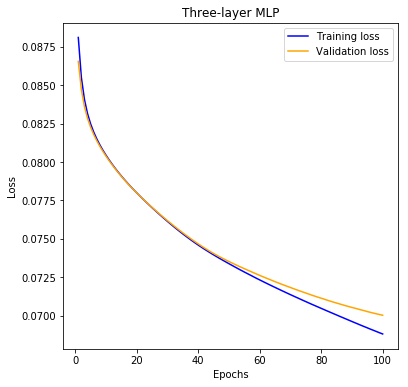

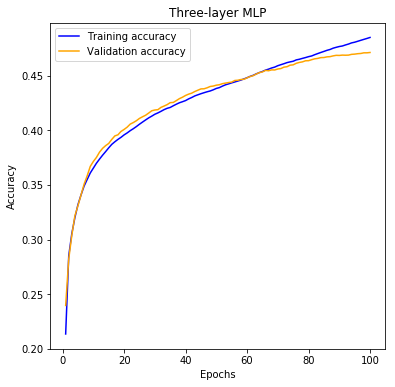

In [11]:
# Plot of Losses
history_dict_2 = history_2.history
# history_dict.keys()
loss_values_2 = history_dict_2['loss']
val_loss_values_2 = history_dict_2['val_loss']
acc_values_2 = history_dict_2['acc']
val_acc_values_2 = history_dict_2['val_acc']

epochs_index = range(1,len(loss_values_2)+1)
fig_loss_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_2, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_2, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_2,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_2,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Plots

In [12]:
fig_accuracy_2.savefig('fig_accuracy_cifar_2.eps', format='eps', dpi=2000)

# The Third Model (Residual Connection) (Hinge Loss)

Input -> Fully Connected (4000) -> ReLU -> Fully Connected (3072) -> Add Input -> ReLU -> Fully Connected (4000) -> ReLU -> Fully Connected (10) -> Softmax -> Categorical hinge loss

In [13]:
# model
z0 = tf.keras.layers.Input(shape=(3072,))
z1 = tf.keras.layers.Dense(4e3, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z0)
z2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z1)
z2 = tf.keras.layers.Add()([z2, z0])
z3 = tf.keras.layers.Dense(4e3, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z2)
#y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True)(z3)
y_mlp_3 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z3)

model_3 = tf.keras.models.Model(inputs=z0, outputs=y_mlp_3)

model_3.summary()

sgd3 = tf.keras.optimizers.SGD(lr=0.05, decay=0, momentum=0, nesterov=False)
model_3.compile(loss='categorical_hinge', optimizer=sgd3, metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 4000)         12292000    input_3[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 3072)         12291072    dense_9[0][0]                    
__________________________________________________________________________________________________
add_2 (Add)                     (None, 3072)         0           dense_10[0][0]                   
                                                                 input_3[0][0]                    
__________

## Fit the Model using Back Propagation (Vanilla SGD)

In [14]:
history_3 = model_3.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score_3 = model_3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])
#print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 3s - loss: 1.1854 - acc: 0.2457 - val_loss: 1.0046 - val_acc: 0.2595
Epoch 2/100
 - 3s - loss: 1.0041 - acc: 0.3002 - val_loss: 1.0044 - val_acc: 0.2588
Epoch 3/100
 - 3s - loss: 1.0029 - acc: 0.3324 - val_loss: 1.0033 - val_acc: 0.3336
Epoch 4/100
 - 3s - loss: 1.0022 - acc: 0.3533 - val_loss: 1.0030 - val_acc: 0.3283
Epoch 5/100
 - 3s - loss: 1.0015 - acc: 0.3700 - val_loss: 1.0026 - val_acc: 0.3620
Epoch 6/100
 - 3s - loss: 1.0007 - acc: 0.3874 - val_loss: 1.0018 - val_acc: 0.3421
Epoch 7/100
 - 3s - loss: 0.9998 - acc: 0.4007 - val_loss: 1.0012 - val_acc: 0.3664
Epoch 8/100
 - 3s - loss: 0.9990 - acc: 0.4077 - val_loss: 1.0007 - val_acc: 0.3881
Epoch 9/100
 - 3s - loss: 0.9980 - acc: 0.4140 - val_loss: 0.9996 - val_acc: 0.3930
Epoch 10/100
 - 3s - loss: 0.9966 - acc: 0.4224 - val_loss: 0.9983 - val_acc: 0.4122
Epoch 11/100
 - 3s - loss: 0.9951 - acc: 0.4257 - val_loss: 0.9971 - val_acc: 0.4149
Epoch 12/100
 - 3s - los

Epoch 97/100
 - 3s - loss: 0.7430 - acc: 0.6403 - val_loss: 0.9590 - val_acc: 0.4827
Epoch 98/100
 - 3s - loss: 0.7344 - acc: 0.6458 - val_loss: 1.0431 - val_acc: 0.4579
Epoch 99/100
 - 3s - loss: 0.7367 - acc: 0.6440 - val_loss: 0.9065 - val_acc: 0.5178
Epoch 100/100
 - 2s - loss: 0.7303 - acc: 0.6490 - val_loss: 0.9237 - val_acc: 0.5030
Test loss: 0.9237394744873046
Test accuracy: 0.503


## Loss and Accuracy Plots

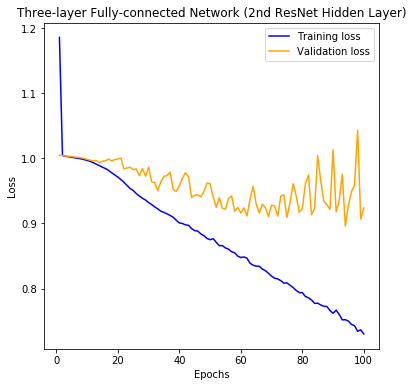

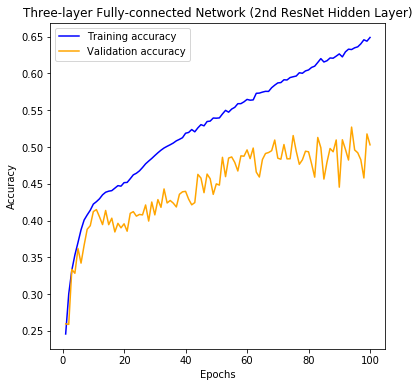

In [15]:
# Plot of Losses
history_dict_3 = history_3.history
# history_dict.keys()
loss_values_3 = history_dict_3['loss']
val_loss_values_3 = history_dict_3['val_loss']
acc_values_3 = history_dict_3['acc']
val_acc_values_3 = history_dict_3['val_acc']

epochs_index = range(1,len(loss_values_3)+1)
fig_loss_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_3, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_3, 'b', c='orange', label='Validation loss')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_3,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_3,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Plots

In [16]:
fig_accuracy_3.savefig('fig_accuracy_cifar_3.eps', format='eps', dpi=2000)

# The Fourth Model (MLP) (Hinge Loss)

Input -> Fully Connected (4000) -> ReLU -> Fully Connected (1000) -> ReLU -> Fully Connected (4000) -> ReLU -> Fully Connected (10) -> Softmax -> Categorical hinge loss

In [17]:
# model
p0 = tf.keras.layers.Input(shape=(3072,))
p1 = tf.keras.layers.Dense(4e3, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(p0)
p2 = tf.keras.layers.Dense(1e3, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(p1)
p3 = tf.keras.layers.Dense(4e3, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(p2)
y_mlp_4 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(p3)

model_4 = tf.keras.models.Model(inputs=p0, outputs=y_mlp_4)

model_4.summary()

sgd4 = tf.keras.optimizers.SGD(lr=0.05, decay=0, momentum=0, nesterov=False)
model_4.compile(loss='categorical_hinge', optimizer=sgd4, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 4000)              12292000  
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              4001000   
_________________________________________________________________
dense_15 (Dense)             (None, 4000)              4004000   
_________________________________________________________________
dense_16 (Dense)             (None, 10)                40010     
Total params: 20,337,010
Trainable params: 20,337,010
Non-trainable params: 0
_________________________________________________________________


## Fit the Model using Back Propagation (Vanilla SGD; lr = 0.05)

In [18]:
history_4 = model_4.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score_4 = model_4.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_4[0])
print('Test accuracy:', score_4[1])
#print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 2s - loss: 1.3392 - acc: 0.1254 - val_loss: 1.0090 - val_acc: 0.1276
Epoch 2/100
 - 2s - loss: 1.0115 - acc: 0.1488 - val_loss: 1.0113 - val_acc: 0.1301
Epoch 3/100
 - 2s - loss: 1.0104 - acc: 0.1637 - val_loss: 1.0089 - val_acc: 0.1911
Epoch 4/100
 - 2s - loss: 1.0105 - acc: 0.1694 - val_loss: 1.0117 - val_acc: 0.1861
Epoch 5/100
 - 2s - loss: 1.0090 - acc: 0.1847 - val_loss: 1.0097 - val_acc: 0.1812
Epoch 6/100
 - 2s - loss: 1.0086 - acc: 0.1932 - val_loss: 1.0056 - val_acc: 0.2421
Epoch 7/100
 - 2s - loss: 1.0084 - acc: 0.1962 - val_loss: 1.0074 - val_acc: 0.2233
Epoch 8/100
 - 2s - loss: 1.0077 - acc: 0.2095 - val_loss: 1.0079 - val_acc: 0.2341
Epoch 9/100
 - 2s - loss: 1.0074 - acc: 0.2191 - val_loss: 1.0039 - val_acc: 0.2244
Epoch 10/100
 - 2s - loss: 1.0069 - acc: 0.2273 - val_loss: 1.0058 - val_acc: 0.1731
Epoch 11/100
 - 2s - loss: 1.0068 - acc: 0.2325 - val_loss: 1.0070 - val_acc: 0.2381
Epoch 12/100
 - 2s - los

Epoch 97/100
 - 2s - loss: 0.8942 - acc: 0.4703 - val_loss: 0.9409 - val_acc: 0.4113
Epoch 98/100
 - 2s - loss: 0.8978 - acc: 0.4629 - val_loss: 0.9252 - val_acc: 0.4246
Epoch 99/100
 - 2s - loss: 0.8914 - acc: 0.4706 - val_loss: 0.9147 - val_acc: 0.4372
Epoch 100/100
 - 2s - loss: 0.8906 - acc: 0.4686 - val_loss: 0.9136 - val_acc: 0.4335
Test loss: 0.9136101854324341
Test accuracy: 0.4335


## Loss and Accuracy Plots

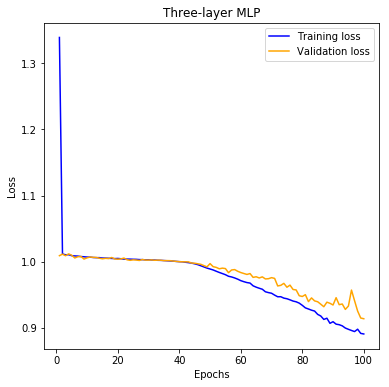

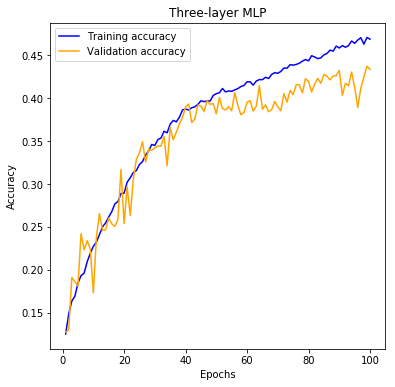

In [19]:
# Plot of Losses
history_dict_4 = history_4.history
# history_dict.keys()
loss_values_4 = history_dict_4['loss']
val_loss_values_4 = history_dict_4['val_loss']
acc_values_4 = history_dict_4['acc']
val_acc_values_4 = history_dict_4['val_acc']

epochs_index = range(1,len(loss_values_4)+1)
fig_loss_4 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_4, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_4, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy_4 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_4,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_4,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Plots

In [20]:
fig_accuracy_4.savefig('fig_accuracy_cifar_4.eps', format='eps', dpi=2000)